In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
#import matplotlib.patches as patches
#import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
#from scipy import stats
import math
import os
import pickle
#from matplotlib.patches import Rectangle


plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses_single = Masses.groupby('A').apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0_single = Masses_single['A'].to_numpy()
Z0_single = Masses_single['Z'].to_numpy()
N0_single = Masses_single['N'].to_numpy()
Element_single = Masses_single['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_single = Masses_single['Ebinding'].to_numpy()

Energies_unc0_single = Masses_single['E_unc'].to_numpy()

# extract 3 nucleon around maximum
Masses_triple = Masses.sort_values(['A','Ebinding'],ascending=False).groupby('A').head(3)

A0_triple = Masses_triple['A'].to_numpy()
Z0_triple = Masses_triple['Z'].to_numpy()
N0_triple = Masses_triple['N'].to_numpy()
Element_triple = Masses_triple['Element'].to_numpy()

# convert energies per nucleon to energies
Energies0_triple = Masses_triple['Ebinding'].to_numpy()

Energies_unc0_triple = Masses_triple['E_unc'].to_numpy()

In [3]:
# define parameter space

theta_0_bound = np.array([0, 40]).reshape(1,-1)
theta_1_bound = np.array([-50, 0]).reshape(1,-1)
theta_2_bound = np.array([-3, 3]).reshape(1,-1)
theta_3_bound = np.array([-50, 0]).reshape(1,-1) # keep
theta_4_bound = np.array([0, 40]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound), axis=0)


print(len(A0_single))
print(len(Masses['Ebinding']))

258
2469


In [4]:
def LiquidDropModel(params, A, Z, N):
    
    if len(params) == 4:
        a1, a2, a3, a4 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A)
        return EB/A
    else:
        a1, a2, a3, a4, a5 = params
        EB = (a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5)))
        return EB/A
    

In [5]:
def create_model_error(_A):
    
    sigma_model = np.zeros(len(_A))     
        
    for i in range(len(_A)):
        if _A[i] < 40:
            sigma_model[i] = 0.09


        elif _A[i] < 140:
            sigma_model[i] = 0.05

        elif _A[i] < 200:
            sigma_model[i] = 0.04
        else:
            sigma_model[i] = 0.02
            
    return sigma_model


In [6]:
# define observational data for each wave

# wave 1 - A < 40
obs_data_wave1 = Energies0_single[10:30:2]
A_wave1 = A0_single[10:30:2]
Z_wave1 = Z0_single[10:30:2]
N_wave1 = N0_single[10:30:2]
variables_wave1 = np.concatenate((A_wave1.reshape(-1,1),Z_wave1.reshape(-1,1),\
                            N_wave1.reshape(-1,1)), axis=1)

sigma_obs_wave1 = Energies_unc0_single[10:30:2]
sigma_model_wave1 = create_model_error(A_wave1)


# wave 2 - A < 140
obs_data_wave2 = Energies0_single[10:130:3]
A_wave2 = A0_single[10:130:3]
Z_wave2 = Z0_single[10:130:3]
N_wave2 = N0_single[10:130:3]
variables_wave2 = np.concatenate((A_wave2.reshape(-1,1),Z_wave2.reshape(-1,1),\
                            N_wave2.reshape(-1,1)), axis=1)

sigma_obs_wave2 = Energies_unc0_single[10:130:3]
sigma_model_wave2 = create_model_error(A_wave2)


# wave 3 - A < 200
obs_data_wave3 = Energies0_single[10:190:3]
A_wave3 = A0_single[10:190:3]
Z_wave3 = Z0_single[10:190:3]
N_wave3 = N0_single[10:190:3]
variables_wave3 = np.concatenate((A_wave3.reshape(-1,1),Z_wave3.reshape(-1,1),\
                            N_wave3.reshape(-1,1)), axis=1)

sigma_obs_wave3 = Energies_unc0_single[10:190:3]
sigma_model_wave3 = create_model_error(A_wave3)


# wave 4 - A > 200
obs_data_wave4 = Energies0_single[10:-1:3]
A_wave4 = A0_single[10:-1:3]
Z_wave4 = Z0_single[10:-1:3]
N_wave4 = N0_single[10:-1:3]
variables_wave4 = np.concatenate((A_wave4.reshape(-1,1),Z_wave4.reshape(-1,1),\
                            N_wave4.reshape(-1,1)), axis=1)

sigma_obs_wave4 = Energies_unc0_single[10:-1:3]
sigma_model_wave4 = create_model_error(A_wave4)


# wave 5 - introduce ap - all data such that 3 points around E minimum are captured
obs_data_wave5 = np.flip(Energies0_triple)[30:-1:4]
A_wave5 = np.flip(A0_triple)[30:-1:4]
Z_wave5 = np.flip(Z0_triple)[30:-1:4]
N_wave5 = np.flip(N0_triple)[30:-1:4]
variables_wave5 = np.concatenate((A_wave5.reshape(-1,1),Z_wave5.reshape(-1,1),\
                            N_wave5.reshape(-1,1)), axis=1)

sigma_obs_wave5 = np.flip(Energies_unc0_triple)[30:-1:4]
sigma_model_wave5 = create_model_error(A_wave5)


obs_data = [obs_data_wave1, obs_data_wave2, obs_data_wave3, obs_data_wave4, obs_data_wave5, obs_data_wave5]
sigma_obs = [sigma_obs_wave1, sigma_obs_wave2, sigma_obs_wave3, sigma_obs_wave4, sigma_obs_wave5, sigma_obs_wave5]
sigma_model = [sigma_model_wave1, sigma_model_wave2, sigma_model_wave3, sigma_model_wave4, sigma_model_wave5, sigma_model_wave5]

variables = [variables_wave1, variables_wave2, variables_wave3, variables_wave4, variables_wave5, variables_wave5]

sigma_method = [np.zeros_like(sigmas) for sigmas in sigma_model]

In [25]:
for i in range(len(obs_data)):
    print(len(obs_data[i]))

10
40
60
83
182
182


# History Matching - Separate Waves

In [7]:
volshapes = ['gaussian', 'hypercube', 'hypercube_rot', 'ellipsoid']

In [8]:
nwaves = 5
ndim = 5
nsamples = 1 * (10**6)
volshape = 'hypercube'

In [9]:
# initialise history matching class
HM = historymatch.HistoryMatch(ndim, filename='result_dict', emulator='GP', volume_shape=volshape)
# initialise results class
Results = historymatch.Results('resultfile')

In [10]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel)

HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1], ninactive=1, inactive_wave = 5, sigma_inactive=0.02)


wave1 = HM.run_wave(1, obs_data[0], sigma_obs[0], sigma_model[0], sigma_method[0], variables[0], nsamples=nsamples, ntraining=200, emulate=False)

100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]

Number of Non-Implausible Samples: 625


In [11]:
HM.store_result(Results, wave=1, wave_results = wave1)

In [12]:
results_wave2 = HM.run_wave(2, obs_data[1], sigma_obs[1], sigma_model[1], sigma_method[1], variables[1], nsamples=nsamples, ntraining=200, emulate=False)

100%|███████████████████████████████████████████| 40/40 [00:57<00:00,  1.43s/it]


Number of Non-Implausible Samples: 70


In [13]:
HM.store_result(Results, wave=2, wave_results = results_wave2)

In [14]:
emulator_output1 = Results.emulator_mu[0]
emulator_sd1 = Results.emulator_sd[0]
training_pts1 = Results.parameter_train1[0]

In [15]:
emulator_output2 = Results.emulator_mu[1]
emulator_sd2 = Results.emulator_sd[1]
training_pts2 = Results.parameter_train1[1]

In [16]:
uniform_samples1 = np.zeros((100,4))

for i in range(4):
    uniform_samples1[:,i] = np.linspace(parameter_bounds[i,0], parameter_bounds[i,1], 100)

In [17]:
bounds = utils.locate_boundaries(Results.nonimplausible[0][:,:-1], 4)

In [18]:
print(bounds)

[[ 6.6661400e+00  2.4362660e+01]
 [-3.5509875e+01 -3.5975000e-02]
 [-2.1017310e+00  9.8195100e-01]
 [-4.9964375e+01 -3.8250000e-03]]


In [19]:
uniform_samples2 = np.zeros((100,4))

for i in range(4):
    uniform_samples2[:,i] = np.linspace(bounds[i,0], bounds[i,1], 100)

In [20]:
true_output = LiquidDropModel(uniform_samples1.T, *variables_wave1[0])
training_output = LiquidDropModel(training_pts1.T, *variables_wave1[0])

(-52.0, 2.0)

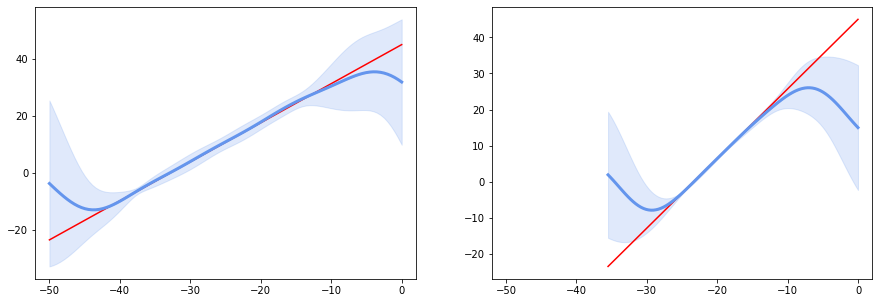

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
#ax.scatter(training_pts[:,0], training_output)
ax1.plot(uniform_samples1[:,1], true_output, color='red')
ax1.plot(uniform_samples1[:,1], emulator_output1, color='cornflowerblue', lw=3)
ax1.fill_between(uniform_samples1[:,1], emulator_output1, emulator_output1+3*emulator_sd1, color='cornflowerblue', alpha=0.2)
ax1.fill_between(uniform_samples1[:,1], emulator_output1, emulator_output1-3*emulator_sd1, color='cornflowerblue', alpha=0.2)

ax2.plot(uniform_samples2[:,1], true_output, color='red')
ax2.plot(uniform_samples2[:,1], emulator_output2, color='cornflowerblue', lw=3)
ax2.fill_between(uniform_samples2[:,1], emulator_output2, emulator_output2+3*emulator_sd2, color='cornflowerblue', alpha=0.2)
ax2.fill_between(uniform_samples2[:,1], emulator_output2, emulator_output2-3*emulator_sd2, color='cornflowerblue', alpha=0.2)

ax1.set_xlim([-52,2])
ax2.set_xlim([-52,2])

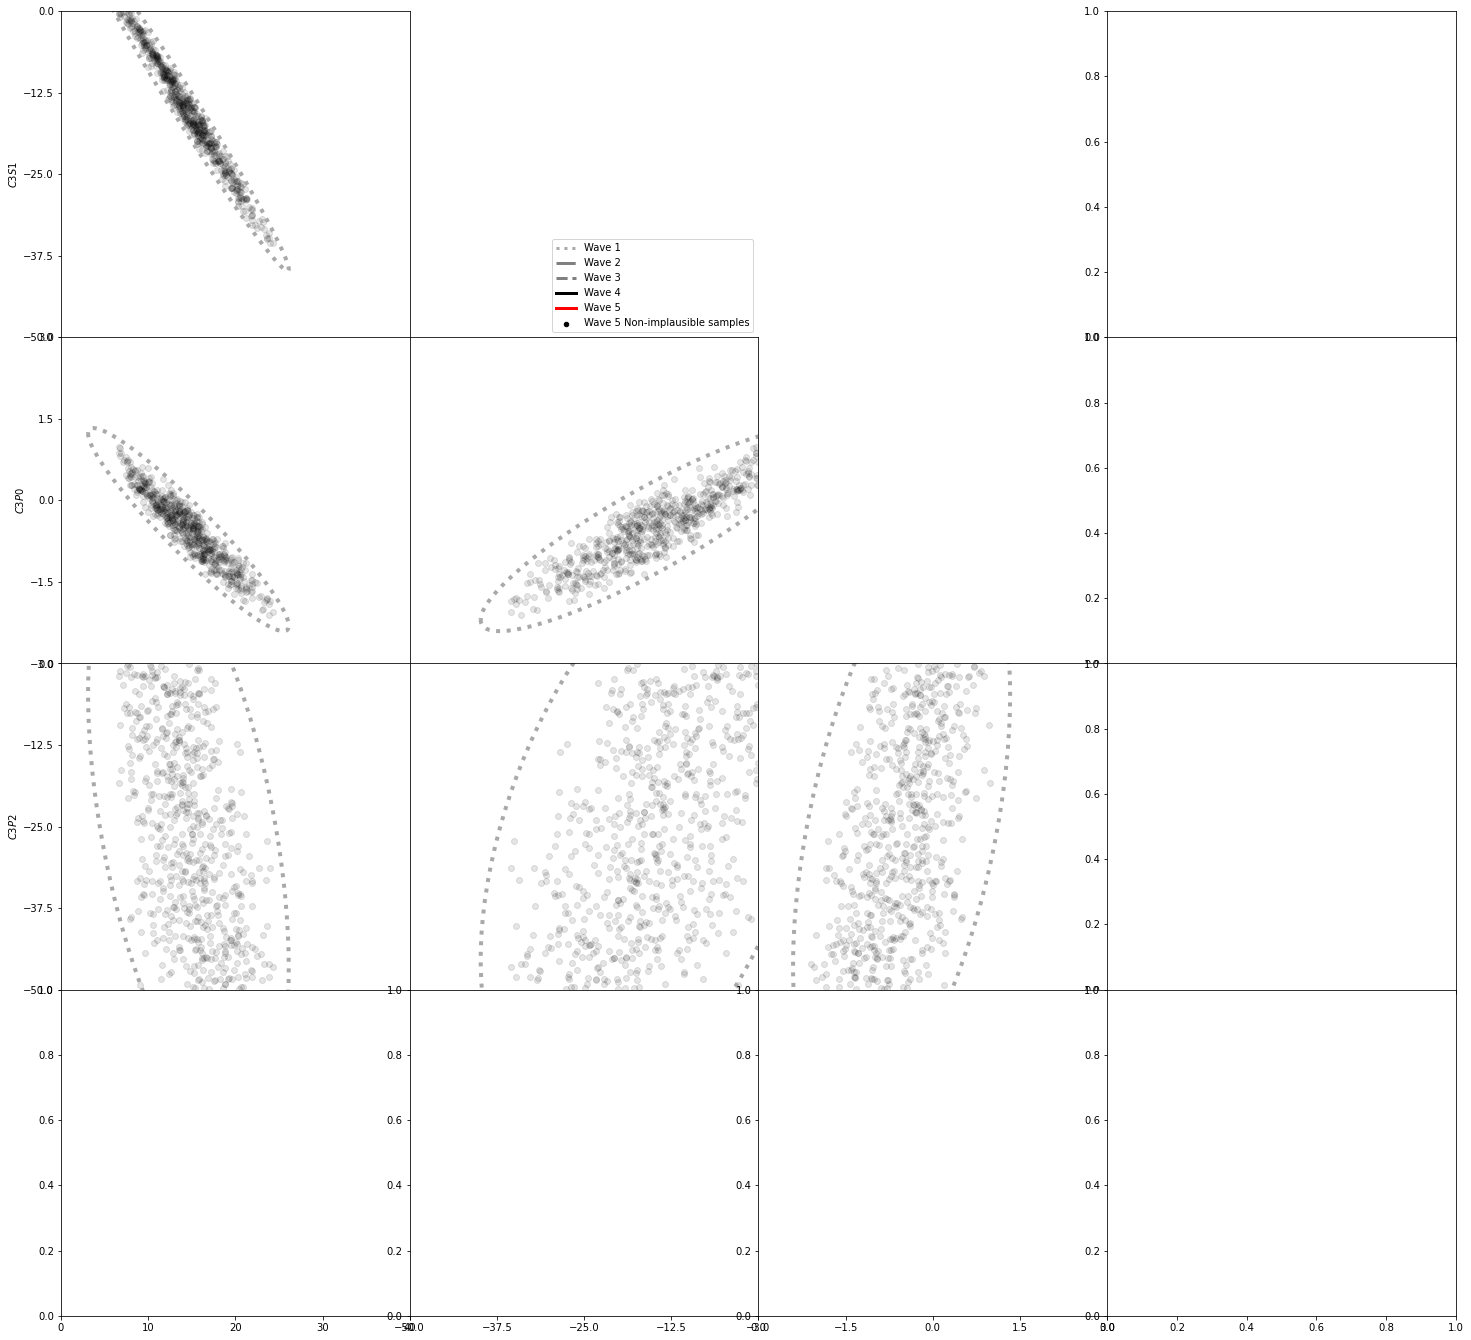

In [22]:
colors = ['darkgrey', 'grey', 'grey', 'black', 'red']
linestyles = [':', '-.', '--','-','-', '']
theta_names = [r'$C1S0$', r'$C3S1$', r'$C3P0$', r'$C3P2$']
dec_list = [0,0,0,0,0,0]

fig, axes = plt.subplots(ndim, ndim-1, figsize=(25,30), sharex='col')

for k in range(1):
    
    # find mean and covariance of nonimplausible region
    nonimplausible = Results.nonimplausible[k]
    historymatch_cov = np.cov(nonimplausible[:,:-1].T)
    historymatch_mean = np.mean(nonimplausible[:,:-1], axis=0)
    
    dims = 4
    
    # plot ellipses for each dimension
    for i in range(dims-1):
        for j in range(dims):
            ax = axes[j,i]
            
            if i != 0:
                ax.axes.yaxis.set_visible(False)
            #if j != 2:
                #ax.axes.xaxis.set_visible(False)
                
            if i < j:
                
                    
                param_cov = np.array([[historymatch_cov[i,i], historymatch_cov[i,j]],[historymatch_cov[j,i], historymatch_cov[j,j]]])
                param_mean = [historymatch_mean[i],historymatch_mean[j]]

                plot.get_cov_ellipse(param_cov, param_mean, 3, 9.210, ax, colors[k], linestyles[k], lw=4)
                    
                ax.set_xlabel(theta_names[i])
                ax.set_ylabel(theta_names[j])
                
                ax.scatter(Results.nonimplausible[k][:,i], Results.nonimplausible[k][:,j], alpha=0.1, color='black')
                
                # set limits to correspond to starting range
                ax.set_xlim([parameter_bounds[i,0],parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0],parameter_bounds[j,1]])

                ax.set_xticks(np.linspace(parameter_bounds[i,0], parameter_bounds[i,1], 5))
                ax.set_yticks(np.linspace(parameter_bounds[j,0], parameter_bounds[j,1], 5))

                
                #ax.axis('square')

            elif i == j:
                if i == 1:
                    pts = ax.scatter(100,100,color='black', s=20)
                    lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=linestyles[c]) for c in range(len(colors))]
                    lines.append(pts)
                    labels = ['Wave 1', 'Wave 2', 'Wave 3', 'Wave 4', 'Wave 5', 'Wave 5 Non-implausible samples']
                    ax.legend(lines, labels, loc='lower right')
                    ax.axis('off') 
                else:
                    ax.axis('off')    
            else:
                ax.axis('off')
                
for ax in axes[0, :]:
    fig.delaxes(ax)

fig.subplots_adjust(wspace=0, hspace=0)

# History Match - All Waves

In [23]:
# initialise all observational data and run multiple waves
#HM.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, sigma_method=sigma_method)

#results = HM.run(nwaves=nwaves, ntraining=1000, nsamples=nsamples, emulate=True)

In [24]:
# initialise history matching class
HM2 = historymatch.HistoryMatch(ndim, filename='result_dict', emulator='GP', volume_shape='ellipsoid')
# initialise results class
Results2 = historymatch.Results('resultfile')

ToyModel2 = historymatch.Simulator(HM2)
ToyModel2.set_simulator(LiquidDropModel)

HM2.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1], ninactive=1, inactive_wave = 5, sigma_inactive=0.02)

HM2.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, sigma_method=sigma_method)

results_hc_rot = HM2.run(nwaves=nwaves, ntraining=100, nsamples=nsamples)

Running wave 1


100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Number of Non-Implausible Samples: 635
Running wave 2


 38%|████████████████▏                          | 15/40 [00:21<00:36,  1.45s/it]


KeyboardInterrupt: 

In [ ]:
dictionary = {'Nsamples : ' : len(results.samples[0]), 'Noutputs : ' : len(obs_data)}

keys = np.array(['Nsamples', 'Noutputs']).reshape(1,-1)
vals = np.array([len(results.samples[0]), len(obs_data)]).reshape(1,-1)

In [ ]:

shape = volshape
for wave in range(nwaves):
    file = open("data/w{}_{}_nonimp.txt".format(wave+1,shape), "w")
    np.savetxt(file, results.nonimplausible[wave])
    file.close()
    file3 = open("data/w{}_{}_samples.txt".format(wave+1,shape), "w")
    np.savetxt(file3, results.samples_I[wave])
    file3.close()
#file2 = open("data/details_{}.txt".format(shape), "w")
#np.savetxt(file2, keys, fmt="%s")
#np.savetxt(file2, vals, fmt="%d")
#file2.close()

In [ ]:

shape2 = 'hypercube_rot'
for wave in range(nwaves):
    file = open("data/w{}_{}_nonimp.txt".format(wave+1,shape2), "w")
    np.savetxt(file, results_hc_rot.nonimplausible[wave])
    file.close()
    file3 = open("data/w{}_{}_samples.txt".format(wave+1,shape2), "w")
    np.savetxt(file3, results_hc_rot.I_samples[wave])
    file3.close()
#file2 = open("data/details_{}.txt".format(shape2), "w")
#np.savetxt(file2, keys, fmt="%s")
#np.savetxt(file2, vals, fmt="%d")
#file2.close()